In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

## More Examples

In [2]:
births = Table.read_table('baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


280


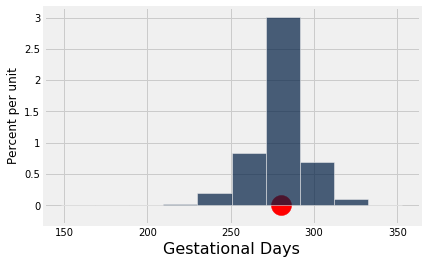

In [3]:
births.hist("Gestational Days")
median_days = percentile(50,births.column(1))
print(median_days)
plots.scatter(median_days, 0, color='red', s=400)

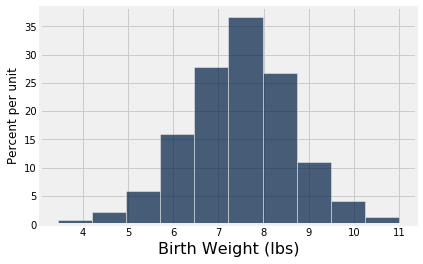

In [4]:
births.with_column(
    'Birth Weight (lbs)', births.column('Birth Weight')/16
).hist('Birth Weight (lbs)')

In [5]:
babies = births.select('Birth Weight', 'Gestational Days')
babies

Birth Weight,Gestational Days
120,284
113,282
128,279
108,282
136,286
138,244
132,245
120,289
143,299
140,351


In [6]:
ratios = babies.with_column(
    'Ratio BW/GD', babies.column(0)/babies.column(1)
)
ratios

Birth Weight,Gestational Days,Ratio BW/GD
120,284,0.422535
113,282,0.400709
128,279,0.458781
108,282,0.382979
136,286,0.475524
138,244,0.565574
132,245,0.538776
120,289,0.415225
143,299,0.478261
140,351,0.39886


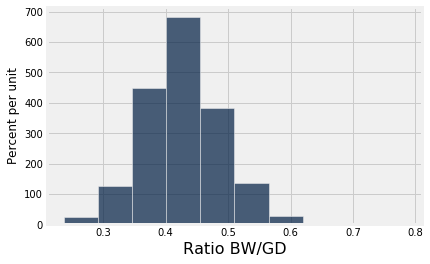

In [7]:
ratios.hist('Ratio BW/GD')

In [8]:
median_ratio = np.median(ratios.column('Ratio BW/GD'))
median_ratio

0.42907801418439717

In [9]:
median_ratio*median_days / 16

7.50886524822695

In [10]:
np.median(ratios.column('Birth Weight')) / 16

7.5

In [13]:
# use bootstrap to estimate 95% confidence interval
# for median BW/GD in population

resampled_medians = make_array()
for i in np.arange(1000):
    resample = ratios.sample()
    median = np.median(resample.column('Ratio BW/GD'))
    resampled_medians = np.append(resampled_medians, median)
    
interval_95 = [percentile(2.5, resampled_medians),
               percentile(97.5, resampled_medians)]


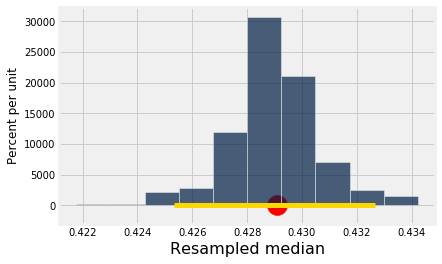

In [14]:
Table().with_column('Resampled median', resampled_medians).hist('Resampled median')
plots.plot(interval_95, [0, 0], color='gold', lw=5)
plots.scatter(median_ratio, 0, color='red', s=400)


# Maternal Ages

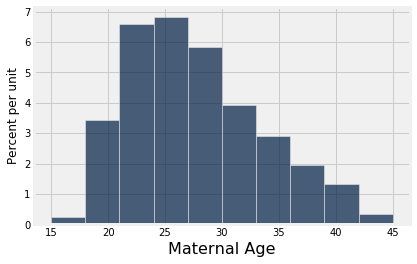

In [15]:
# how old are mothers in the sample?
births.hist("Maternal Age")

In [16]:
pop_mean = np.mean(births.column("Maternal Age"))
pop_mean

27.228279386712096

[26.88841567291312, 27.56388415672913]


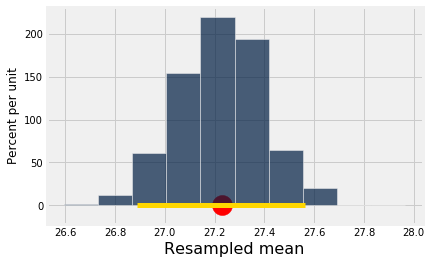

In [19]:
# use bootstrap to estimate 95% confidence interval
# for mean age of mothers in population

resampled_means = make_array()
for i in np.arange(1000):
    resample = births.sample()
    mean = np.mean(resample.column('Maternal Age'))
    resampled_means = np.append(resampled_means, mean)
    
interval_95 = [percentile(2.5, resampled_means),
               percentile(97.5, resampled_means)]
print(interval_95)
Table().with_column('Resampled mean', resampled_means).hist('Resampled mean')
plots.plot(interval_95, [0, 0], color='gold', lw=5)
plots.scatter(pop_mean, 0, color='red', s=400)

* **Null:** Population mean is 28
* **Alternative:** Population mean is not 28

# Does smoking affect fetal growth?

* **Null:** There is no difference in growth rates for smokers vs nonsmokers
* **Alternative:** Growth rate is different for smokers

In [20]:
def growth_rate(bw, gd):
    return bw/gd

In [21]:
bw_per_gd = births.apply(growth_rate, "Birth Weight", "Gestational Days")
births = births.with_column("Ratio BW/GD", bw_per_gd)
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker,Ratio BW/GD
120,284,27,62,100,False,0.422535
113,282,33,64,135,False,0.400709
128,279,28,64,115,True,0.458781
108,282,23,67,125,True,0.382979
136,286,25,62,93,False,0.475524
138,244,33,62,178,False,0.565574
132,245,23,65,140,False,0.538776
120,289,25,62,125,False,0.415225
143,299,30,66,136,True,0.478261
140,351,27,68,120,False,0.39886


In [22]:
smoker_median = np.median(births.where("Maternal Smoker", True).column("Ratio BW/GD"))
nonsmoker_median = np.median(births.where("Maternal Smoker", False).column("Ratio BW/GD"))
print("Median BW/GD for smokers is", smoker_median)
print("Median BW/GD for nonsmokers is", nonsmoker_median)

Median BW/GD for smokers is 0.41007194244604317
Median BW/GD for nonsmokers is 0.4384057971014493


In [23]:
nonsmoker_median*median_days/16

7.672101449275362

In [24]:
def test_statistic(sample):
    smoker_median = np.median(sample.where("Maternal Smoker", True).column("Ratio BW/GD"))
    nonsmoker_median = np.median(sample.where("Maternal Smoker", False).column("Ratio BW/GD"))
    return nonsmoker_median - smoker_median

In [25]:
observed = test_statistic(births)
observed

0.02833385465540611

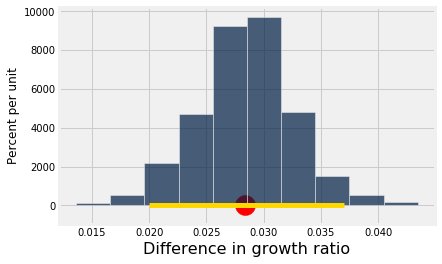

In [26]:
# use bootstrap to estimate 95% confidence interval
# for test statistic

sample_stats = make_array()
for i in np.arange(1000):
    resample = births.sample()
    sample_stat = test_statistic(resample)
    sample_stats = np.append(sample_stats, sample_stat)
    
interval_95 = [percentile(2.5, sample_stats),
               percentile(97.5, sample_stats)]

Table().with_column('Difference in growth ratio', sample_stats).hist('Difference in growth ratio')
plots.plot(interval_95, [0, 0], color='gold', lw=5)
plots.scatter(observed, 0, color='red', s=400)

Conclusion of hypothesis test?